In [495]:
import numpy as np
import pandas as pd
import gensim.downloader as api
import contractions
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate
from tensorflow.keras import Input, Model
from attention import AttentionLayer

In [496]:
df=pd.read_csv('hin.txt',encoding='utf-8',names=['c1','c2','c3'],sep='\t')
df.head()

,c1,c2,c3
0,Wow!,वाह!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,Duck!,झुको!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Duck!,बतख़!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Help!,बचाओ!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
4,Jump.,उछलो.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [497]:
# to remove extra space
df.c1=df.c1.apply(lambda x:" ".join(x.split()))
df.c2=df.c2.apply(lambda x:" ".join(x.split()))
df['c1']=df['c1'].apply(lambda x: x.lower())

In [498]:
df['c1']=df['c1'].apply(lambda x: contractions.fix(x))
translator= str.maketrans('','', string.punctuation)
# dropping all  the punctuations from text data
df['c1'] = df['c1'].apply(lambda x: x.translate(translator))
df['c2'] = df['c2'].apply(lambda x: x.translate(translator))

This tokenizer is very helpful from which we can get frequency of words, dictionaries of word to index & index to word. Which will be used to convert words into numbers(for training) and numbers into words(for prediction)

Padding:- Neural networks also need input (i.e. sentences) in same length So we’ll pad sentences of English and Marathi language with ‘0’ to get length of sentences as maximum length sentence of respective language.

In [499]:
df['c2']=df['c2'].apply(lambda x:"sos "+x+" eos")

In [500]:
eng_list=df['c1'].to_list()
hin_list=df['c2'].to_list()
from tensorflow.keras.preprocessing.text import Tokenizer
def tokenise_sent(sentences):
    tenkin=Tokenizer()
    tenkin.fit_on_texts(sentences)
    return tenkin,tenkin.texts_to_sequences(sentences)

In [501]:
eng_tokeniser,eng_text=tokenise_sent(eng_list)
hin_tokeniser,hin_text=tokenise_sent(hin_list)

In [502]:
hin_vocab=len(hin_tokeniser.word_index)+1
eng_vocab=len(eng_tokeniser.word_index)+1

In [503]:
max_eng_len=max(len(x) for x in eng_text)
max_hin_len=max(len(x) for x in hin_text)

In [504]:
eng_pad_sequence=pad_sequences(eng_text,maxlen=26,padding='post')
hin_pad_sequence=pad_sequences(hin_text,maxlen=max_hin_len,padding='post')
# eng_pad_sequence
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(eng_pad_sequence,hin_pad_sequence,test_size=0.2)

In [505]:
# Encoder
encoder_input=Input(shape=(26,))
embedding = Embedding(eng_vocab,1024)(encoder_input)
encoder=Bidirectional((LSTM(256,return_sequences=True,return_state=True)))
encoded_output, f_state_h, f_state_c,b_state_h, b_state_c =encoder(embedding)
final_h=Concatenate(axis=-1)([f_state_h,b_state_h])
final_c=Concatenate(axis=-1)([f_state_c,b_state_c])
encoder_state=[final_h, final_c]

In [506]:
import keras
import tensorflow as tf

In [507]:
import tensorflow as tf

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query shape: (batch_size, hidden_size)
        # values shape: (batch_size, max_length, hidden_size)

        # Expand dimensions to add time axis to the query
        query_with_time_axis = tf.expand_dims(query, 1)

        # Score calculation
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # Attention weights calculation
        attention_weights = tf.nn.softmax(score, axis=1)

        # Context vector calculation
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Example usage:

In [508]:
# class BahdanauAttention(tf.keras.layers.Layer):
#   '''
#     Layers implements a Bahdanau attention mechanism
#   '''
#   def __init__(self, units: int, name=None):
#     '''
#       :param units - the number of the encoder and decoder hidden units.
#       This value can be obtained from the inputs dimensions but for the 
#       purpose of simplicity we will set it here.
#       :param name - tne name of the layer
#     '''
#     super(BahdanauAttention, self).__init__(name=name)
#     self.fc_encoder_states = Dense(units=units, activation='linear')
#     self.fc_decoder_states = Dense(units=units, activation='linear')
#     self.fc_combined = Dense(units=1, activation='linear')

#   def __call__(self, encoder_states, decoder_hidden_state, 
#                is_verbose=False):
#     '''
#       Calculate forward propagation through the Layer
#       :param encoder_states - encoder hidden states 
#        (batch_size, sequence_length, encoder_lstm_hidden_units)
#       :param decoder_hidden_state - decoder hidden state 
#        (batch_size, decoder_lstm_hidden_units)
#     '''

#     fc_encoder_out = self.fc_encoder_states(encoder_states) 
#     fc_decoder_out = self.fc_decoder_states(decoder_hidden_state)
#     fc_decoder_out = tf.expand_dims(fc_decoder_out, axis=1) 
#     alignment_scores = self.fc_combined(tf.math.tanh(fc_encoder_out + \
#                                                      fc_decoder_out))   
#     softmax_alignment_scores = tf.nn.softmax(alignment_scores, axis=1)
#     context_vector = tf.reduce_sum(
#                         softmax_alignment_scores * encoder_states, 
#                         axis=1)

#     if is_verbose:
#       print(f"Input: encoder_states shape: {encoder_states.shape}, decoder_hidden_state shape: {decoder_hidden_state.shape}")
#       print(f"fc_encoder_out shape: {fc_encoder_out.shape}, fc_decoder_out shape: {fc_decoder_out.shape}")
#       print(f"alignment_scores shape: {alignment_scores.shape}, softmax_alignment_scores shape: {softmax_alignment_scores.shape}")
#       print(f"context_vector shape: {context_vector.shape}")

#     return context_vector, softmax_alignment_scores

In [509]:
# Decoder
decoder_input=Input(shape=(None,))
embedding11 = Embedding(hin_vocab,1024)
embedding1=embedding11(decoder_input)
attention_layer = BahdanauAttention(1024)
decoder=LSTM(512,return_sequences=True,return_state=True)
decoder_outputs, state_h, state_c=decoder(embedding1,initial_state=encoder_state)
(context_vector,attention_weight)=attention_layer(encoded_output,decoder_outputs)

# context_vector = tf.matmul(attention_weight, final_h, transpose_b=True)
# context_vector_expanded = tf.expand_dims(context_vector, 1)
decoder_concat_input=Concatenate(axis=-1)([context_vector, decoder_outputs])

decoder_dense=Dense(units=hin_vocab,activation='softmax')
decoder_final_output=decoder_dense(decoder_concat_input)
model=Model([encoder_input,decoder_input] , decoder_final_output)

In [510]:
context_vector.shape

TensorShape([None, 26, 512])

In [511]:
decoder_outputs.shape

TensorShape([None, None, 512])

WARNING:tensorflow:The following Variables were used in a Lambda layer's call (tf.linalg.matmul_9), but are not present in its tracked objects:   <tf.Variable 'attention_layer_2/W_a:0' shape=(512, 512) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer. i am using bagadnau attention it gives me this error
ChatGPT
The warning you're encountering suggests that there are variables used in a Lambda layer's call that are not tracked by the layer. This often happens when using custom attention mechanisms like Bahdanau attention within a Lambda layer.

In [512]:
decoder_input_data=y_train[:,:-1]
decoder_target_data=y_train[:,1:]
decoder_input_test_data=y_test[:,:-1]
decoder_target_test_data=y_test[:,1:]
encoder_input_data=x_train
encoder_test_data=x_test

In [513]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_65 (InputLayer)       [(None, 26)]                 0         []                            
                                                                                                  
 embedding_49 (Embedding)    (None, 26, 1024)             2420736   ['input_65[0][0]']            
                                                                                                  
 bidirectional_23 (Bidirect  [(None, 26, 512),            2623488   ['embedding_49[0][0]']        
 ional)                       (None, 256),                                                        
                              (None, 256),                                                        
                              (None, 256),                                                 

In [514]:
encoder_test_data.shape

(596, 26)

In [515]:
decoder_input_data.shape

(2383, 26)

In [516]:
model.fit([encoder_input_data,decoder_input_data],decoder_target_data,epochs=5,batch_size=100,validation_data =([encoder_test_data,decoder_input_test_data],decoder_target_test_data))

Epoch 1/5


24/24 [==============================] - 67s 2s/step - loss: 2.9037 - accuracy: 0.6718 - val_loss: 2.3008 - val_accuracy: 0.7037
Epoch 2/5
24/24 [==============================] - 75s 3s/step - loss: 2.0174 - accuracy: 0.7052 - val_loss: 1.9466 - val_accuracy: 0.7055
Epoch 3/5
24/24 [==============================] - 227s 9s/step - loss: 1.8910 - accuracy: 0.7109 - val_loss: 1.8351 - val_accuracy: 0.7295
Epoch 4/5
24/24 [==============================] - 141s 6s/step - loss: 1.7870 - accuracy: 0.7261 - val_loss: 1.7796 - val_accuracy: 0.7410
Epoch 5/5
24/24 [==============================] - 48s 2s/step - loss: 1.7346 - accuracy: 0.7398 - val_loss: 1.7415 - val_accuracy: 0.7431


In [517]:
encoder_model=Model(encoder_input,outputs=[encoded_output,final_h,final_c])
decoder_state_h = Input(shape=(512,)) # This numbers has to be same as units of lstm's on which model is trained
decoder_state_c = Input(shape=(512,))
decoder_hidden_state_input = Input(shape=(26,512)) 
# get decoder states
dec_states = [decoder_state_h, decoder_state_c]
embedding_dec=embedding11(decoder_input)
decoder_outputs2,state_h2,state_c2=decoder(embedding_dec,initial_state=dec_states)
attention_result_inf, attention_weights_inf = attention_layer(decoder_hidden_state_input, decoder_outputs2)
decoder_concat_input_inf = Concatenate( name='concat_layer')([attention_result_inf,decoder_outputs2])
dec_states2= [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)
decoder_model= Model(
                    [decoder_input] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

In [518]:
decoder_outputs2.shape

TensorShape([None, 26, 3063])

In [519]:
decoder_hidden_state_input.shape

TensorShape([None, 26, 512])

In [520]:
encoder_model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_65 (InputLayer)       [(None, 26)]                 0         []                            
                                                                                                  
 embedding_49 (Embedding)    (None, 26, 1024)             2420736   ['input_65[0][0]']            
                                                                                                  
 bidirectional_23 (Bidirect  [(None, 26, 512),            2623488   ['embedding_49[0][0]']        
 ional)                       (None, 256),                                                        
                              (None, 256),                                                        
                              (None, 256),                                                 

In [521]:
decoder_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_66 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_50 (Embedding)    (None, None, 1024)           3136512   ['input_66[0][0]']            
                                                                                                  
 input_67 (InputLayer)       [(None, 512)]                0         []                            
                                                                                                  
 input_68 (InputLayer)       [(None, 512)]                0         []                            
                                                                                           

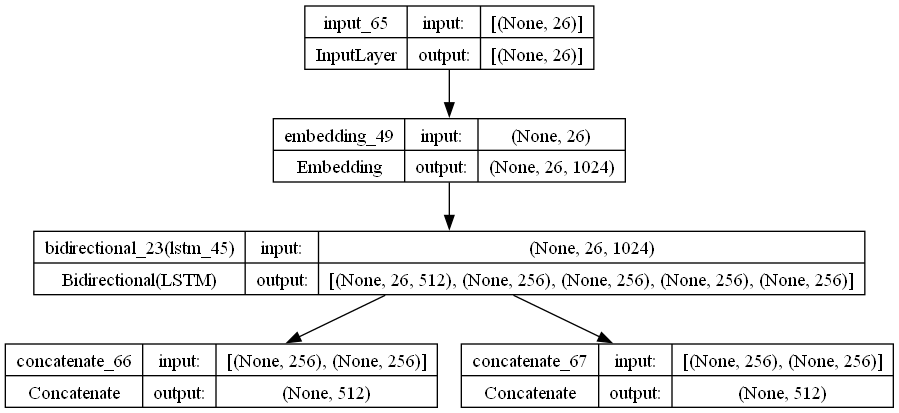

In [522]:
from keras.utils import plot_model
plot_model(encoder_model,"encoder.png",show_shapes=True)

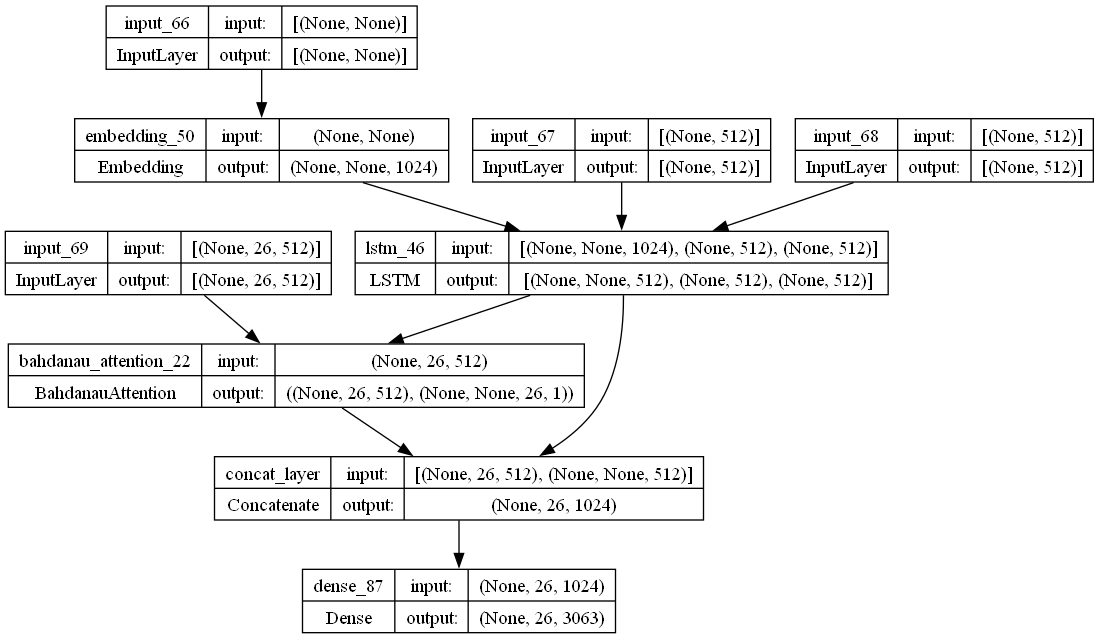

In [523]:
plot_model(decoder_model,"decoder.png",show_shapes=True)

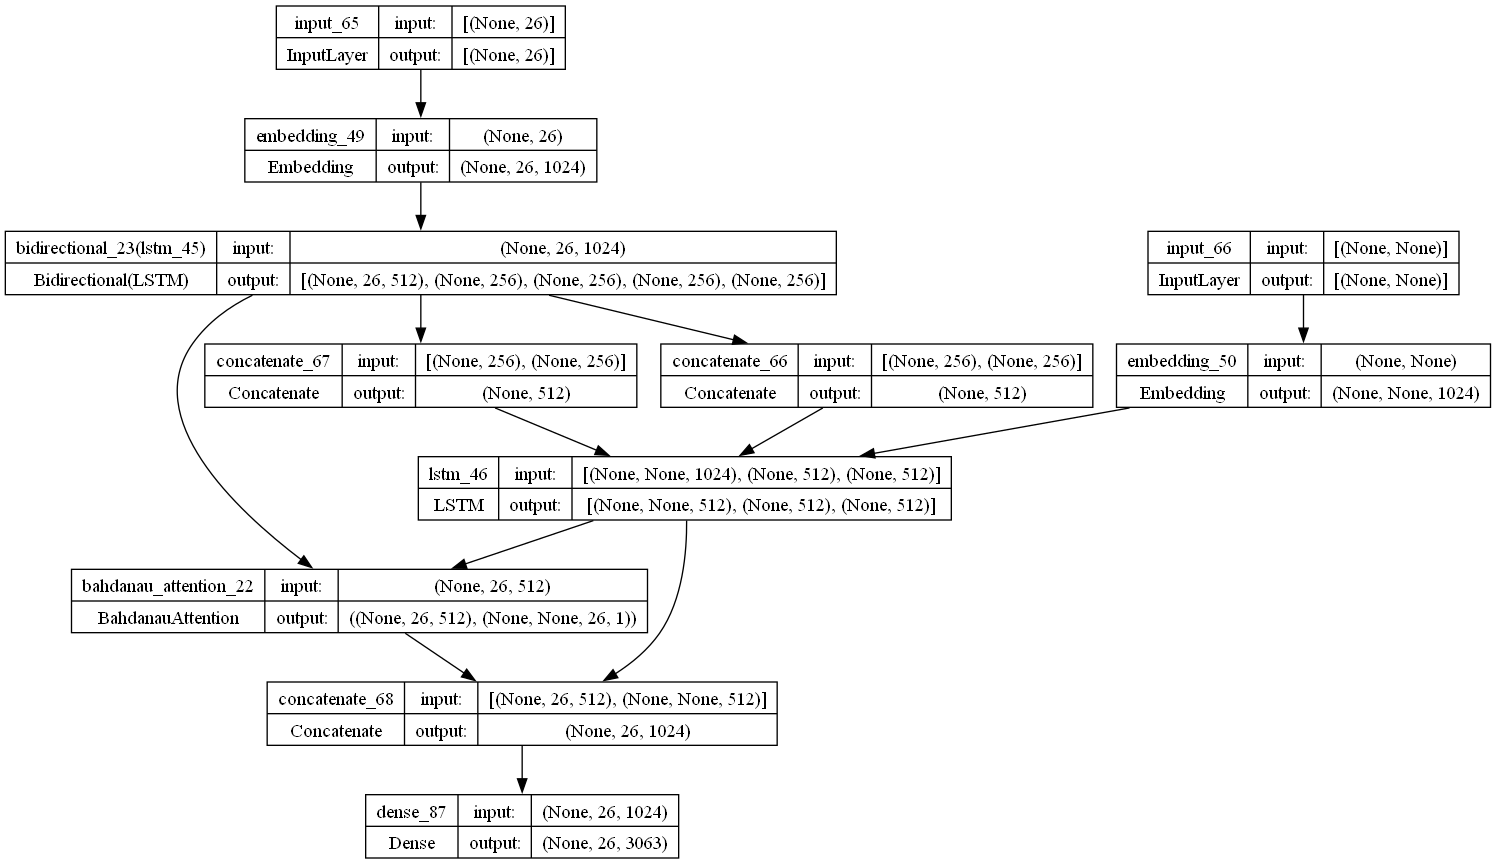

In [524]:
plot_model(model,"model.png",show_shapes=True)

In [562]:
hin_word_index=hin_tokeniser.word_index
hin_index_word=hin_tokeniser.index_word
eng_index_word=eng_tokeniser.index_word

In [584]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    # target_seq = np.zeros((1,26))
    
    # Populate the first character of target sequence with the start character.
    # target_seq[0, 0] = hin_word_index['sos']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    # stop_condition = Falsef\
    # decoded_sentence = ''
    
    # while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
    # Sample a token
    sampled_token_index=[]
    for i in range(26):
            sampled_token_index.append(np.argmax(output_tokens[0][i]))    
        # sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # convert max index number to marathi word
        # print(sampled_token_index)
        # if()
            # 
    print(sampled_token_index)
    sampled_char=[]
    for i in  sampled_token_index:
        if(i!=0):
            sampled_char.append(hin_index_word[i])
        # aapend it to decoded sent
    print(sampled_char)
    # decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
    # if (sampled_char == 'eos' or len(decoded_sentence.split()) >= 36):
    #         stop_condition = True
        
        # Update the target sequence (of length 1).
    target_seq = np.zeros((1,26))
    # target_seq[0, 0] = sampled_token_index+1
        
        # Update states
    enc_h, enc_c = h, c
    
    return sampled_char

In [574]:
x_test=x_test[0].reshape(1,26)
for i in x_test[0]:
    if i!=0:
        print(eng_index_word[i])

what
have
you
been
doing
the
past
three
hours


In [585]:
f=get_predicted_sentence(x_test)
f

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 28ms/step
[6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['मैं', 'मैं']


['मैं', 'मैं']